<a href="https://colab.research.google.com/github/scheung97/EECE5639_ComputerVision/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 # Northeastern University
# EECE5639 Computer Vision

# Spenser Cheung & Tim Liming

# Project 2

import cv2 
import numpy as np 
import os
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from scipy import ndimage
from scipy import signal

from google.colab.patches import cv2_imshow
from google.colab import drive


In [1]:
!python3 --version
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Python 3.7.12
     |████████████████████████████████| 25.0 MB 99 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 27 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
# Mount Google Drive in Google Colab

# Public 'DanaOffice' folder link: 
# https://drive.google.com/drive/folders/1WUWYblxSid4YkRJawACK7tNizW79Zk6h?usp=sharing

# Public 'DanaHallWay1' folder link: 
# https://drive.google.com/drive/folders/1Y-nP4B0Usws3yPL4f0T-pGWNcd-o1qGs?usp=sharing

drive.mount('/content/gdrive', force_remount=True)

office_path = "/content/gdrive/MyDrive/EECE5639_P2_DanaOffice"
hallway_path = "/content/gdrive/MyDrive/EECE5639_P2_DanaHallWay1"

Mounted at /content/gdrive


In [4]:
# i. Read in two images.

# Office
office_files = [filename for filename in sorted(os.listdir(office_path)) if os.path.isfile(os.path.join(office_path, filename))]

office_images = []    
for i in range(0, len(office_files)): 
    img = cv2.imread(os.path.join(office_path, office_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    office_images.append(gray_img)

office_images = np.array(office_images)
print(office_images.shape)


(10, 340, 512)


In [5]:
# i. Read in two images.

# Hallway
hallway_files = [filename for filename in sorted(os.listdir(hallway_path)) if os.path.isfile(os.path.join(hallway_path, filename))]

hallway_images = []
for i in range(0, len(hallway_files)): 
    img = cv2.imread(os.path.join(hallway_path, hallway_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    hallway_images.append(gray_img)

hallway_images = np.array(hallway_images)
print(hallway_images.shape)


(3, 340, 512)


Reduced Images:


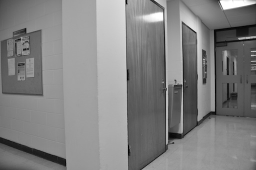

(170, 256)
----------------------------------


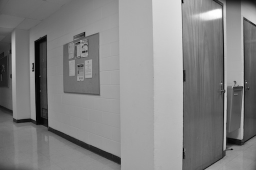

(170, 256)
----------------------------------


In [6]:
# i. Read in two images. (Note: if the images are large, you may want to reduce
# their size to keep running time reasonable! Document in your report the scale
# factor you used.)

use_hall = True
#use_hall = False
if use_hall:
    img1, img2 = np.random.default_rng().choice(hallway_images, 2, replace=False)
else:
    img1, img2 = np.random.default_rng().choice(office_images, 2, replace=False)

#print('Original Images:')
#cv2_imshow(img1)
#print('--------------------------------------------------------------')
#cv2_imshow(img2)
#print('--------------------------------------------------------------')

scale = 0.5
r_img1 = cv2.resize(img1, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
r_img2 = cv2.resize(img2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

print('Reduced Images:')
cv2_imshow(r_img1)
print(r_img1.shape)
print('----------------------------------')
cv2_imshow(r_img2)
print(r_img2.shape)
print('----------------------------------')


R:


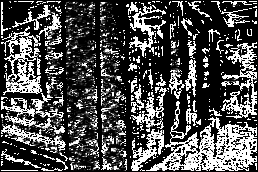

Thresholded R:


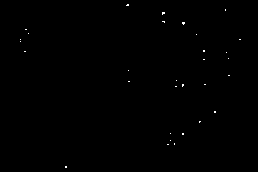

R:


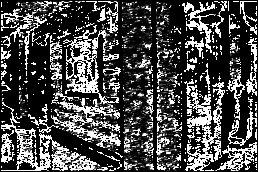

Thresholded R:


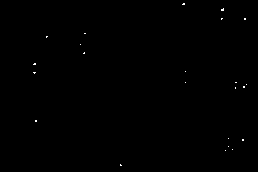

----------------------------------
Harris Corners:


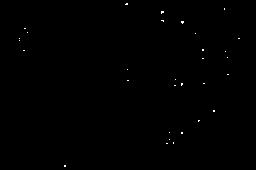

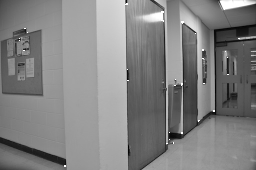

----------------------------------


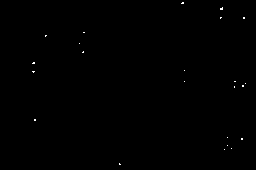

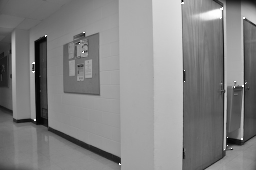

----------------------------------


In [7]:
# ii. Apply Harris corner detector to both images: compute Harris R function 
# over the image, and then do non-maximum suppression to get a sparse set of 
# corner features.

# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
# https://stackoverflow.com/a/56802012

# https://stackoverflow.com/questions/6931362/non-maximum-suppression-in-opencv
# https://fahmifahim.com/2010/10/22/opencv-corner-detection/


def harris1(img):
    # Compute the Image Gradient
    Ix = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    Iy = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

    # Compute products of derivatives at each pixel
    I2x = Ix * Ix
    I2y = Iy * Iy
    Ixy = Ix * Iy

    # Compute the sums of the products at each pixel using a window averaging:
    gauss_window = signal.windows.gaussian(3 * 3, std=1, sym=True)
    gauss_window = np.reshape(gauss_window, (3, 3))

    S2x = signal.convolve2d(gauss_window, I2x) # Gs' * I2x
    S2y = signal.convolve2d(gauss_window, I2y) # Gs’ * I2y 
    Sxy = signal.convolve2d(gauss_window, Ixy) # Gs’ * Ixy

    # Define the Matrix at each pixel
    M_top = np.hstack((S2x, Sxy))
    M_bot = np.hstack((Sxy, S2y))
    M = np.vstack((M_top, M_bot)) # [S2x Sxy ; Sxy S2y]
    #print(M)

    # Compute the response
    k = 0.05
    det_M = (S2x * S2y) - (Sxy * Sxy)
    trace_M = (S2x + S2y)
    R = det_M - k * (trace_M)**2
    print('R:')
    #print(R)
    cv2_imshow(R)

    # Threshold R
    ret, R = cv2.threshold(R, 0.1*np.amax(R), 255, 0)
    print('Thresholded R:')
    #print(R)
    cv2_imshow(R)

    # Compute Nonmax suppression
    image = np.pad(R, ((1, 1), (1, 1)))
    local_max = np.zeros_like(image)

    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            window = image[i-1:i+2, j-1:j+2]
            if image[i,j] == np.amax(window):
                local_max[i,j] = image[i,j]

    # remove padding
    corners = local_max[2:-2, 2:-2]

    return corners, (corners + img)


def harris2(img):
    # find Harris corners
    src = np.float32(img)
    dst = cv2.cornerHarris(src, blockSize=2, ksize=3, k=0.05)

    # result is dilated for marking the corners
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value
    ret, dst = cv2.threshold(dst, 0.01*dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(img, np.float32(centroids), (5,5), (-1,-1), criteria)

    # Now draw them
    res = np.hstack((centroids, corners))
    res = np.int0(res)
    img[res[:,1],res[:,0]] = 255

    corners = np.zeros_like(img)
    corners[res[:,1],res[:,0]] = 255
    return corners, img

# -----------------------------------------

corners1, h_img1 = harris1(r_img1)
corners2, h_img2 = harris1(r_img2)
#cv2_imshow(corners1)
#cv2_imshow(corners2)
print('----------------------------------')

#corners1, h_img1 = harris2(r_img1)
#corners2, h_img2 = harris2(r_img2)

print('Harris Corners:')
cv2_imshow(corners1)
cv2_imshow(h_img1)
print('----------------------------------')
cv2_imshow(corners2)
cv2_imshow(h_img2)
print('----------------------------------')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[  3.         126.           2.         182.           0.99977738]
 [  3.         127.           2.         183.           0.9997561 ]
 [  4.         125.           3.         181.           0.99965203]
 [  4.         126.           3.         182.           0.99993956]
 [  4.         127.           3.         183.           0.99990731]
 [  8.         224.          86.         234.           0.96379483]
 [  9.         224.          83.         245.           0.98590881]
 [ 11.         161.           8.         220.           0.98649532]
 [ 11.         162.           8.         221.           0.99835998]
 [ 11.         163.           8.         222.           0.99839586]
 [ 12.         161.           9.         220.           0.98488587]
 [ 12.         162.           9.         221.           0.99780971]
 [ 12.         163.           9.         222.           0.99796981]
 [ 13.         161.           9.         220.           0.9758895 ]
 [ 20.         161.           3.         181.   

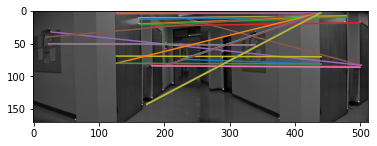

In [8]:
# iii. Find correspondences between the two images: given two set of corners 
# from the two images, compute normalized cross correlation (NCC) of image 
# patches centered at each corner. (Note that this will be O(n2) process.) 
# Choose potential corner matches by finding pair of corners (one from each 
# image) such that they have the highest NCC value. You may also set a 
# threshold to keep only matches that have a large NCC score.

# https://stackoverflow.com/questions/53463087/python-opencv-search-correspondences-of-2-images-with-harris-corner-detection

def corner_coords(corners):
    # get corner locations
    idx = np.where(corners > 0)
    idx = np.array(idx).T
    return idx

def get_patch(img, h, w, n):
    # get n x n patch of image centered at the corner coordinate
    pad_img = np.pad(img, ((n, n), (n, n)))
    patch = pad_img[h+n : h+2*n, w+n : w+2*n]
    return patch

def match_patches(img1, img2, corners1, corners2):
    # match corners between two image
    matches = np.zeros((np.sum(corners1 > 0), 5))

    coords1 = corner_coords(corners1)
    coords2 = corner_coords(corners2)

    for i in range(0, len(coords1)):
        h1, w1 = coords1[i]
        match = np.array([h1,w1, 0,0, 0])
        patch1 = get_patch(img1, h1, w1, 7)

        for j in range(0, len(coords2)):
            h2, w2 = coords2[j]
            patch2 = get_patch(img2, h2, w2, 7)

            #stacked_imgs = np.hstack([patch1, patch2])
            #cv2_imshow(stacked_imgs)

            # NCC
            '''
            len_1 = np.sqrt(np.sum(patch1**2))
            norm_1 = patch1/len_1

            len_2 = np.sqrt(np.sum(patch2**2))
            norm_2 = patch2/len_2

            norm_1 = np.reshape(norm_1, [1, patch1.size])
            norm_2 = np.reshape(norm_2, [patch2.size, 1])

            ncc = np.float(np.dot(norm_1, norm_2))
            '''
            ncc = cv2.matchTemplate(patch1.astype(np.float32), 
                                    patch2.astype(np.float32), 
                                    cv2.TM_CCORR_NORMED)
            #'''

            if ncc >= match[4]:
                #print(i, j)
                #cv2_imshow(stacked_imgs)
                match = np.array([h1,w1, h2,w2, ncc])

        matches[i,:] = match

    return matches

def plot_matches(img1, img2, matches):
    # draw lines between matching patches
    h_offset = img1.shape[0]
    w_offset = img1.shape[1]

    print(matches)
    x = np.copy(matches[:,0:4:2])
    #x[:,1] = x[:,1] + h_offset
    #print(x)
    y = np.copy(matches[:,1:4:2])
    y[:,1] = y[:,1] + w_offset
    #print(y)

    #stacked_imgs = np.vstack([img1, img2])
    stacked_imgs = np.hstack([img1, img2])
    plt.imshow(stacked_imgs, cmap='gray')

    for i in range(0, x.shape[0]):
        if matches[i,-1] >= 0.985:
            # only draw really good matches
            plt.plot(y[i,:], x[i,:])
    
    return

matches = match_patches(h_img1, h_img2, corners1, corners2)
plot_matches(h_img1, h_img2, matches)

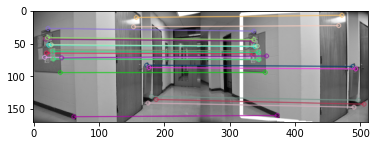

----------------------------------
Homography Matrix:
[[ 7.81863631e-01 -1.62770452e-03  6.27965146e+01]
 [-6.30352132e-02  9.21918867e-01  6.49929576e+00]
 [-8.71796968e-04  3.13716547e-05  1.00000000e+00]]


In [9]:
# iv. Estimate the homography using the above correspondences. Note that these 
# correspondences are likely to have many errors (outliers). That is ok: you 
# should use RANSAC to robustly estimate the homography from the noisy 
# correspondences:

# A. Repeatedly sample minimal number of points needed to estimate a homography
# (4 pts in this case).

# B. Compute a homography from these four points.

# C. Map all points using the homography and comparing distances between 
# predicted and observed locations to determine the number of inliers.

# D. At the end, compute a least-squares homgraphy from ALL the inliers in the
# largest set of inliers.

# https://stackoverflow.com/questions/38491959/how-to-apply-ransac-in-python-opencv
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

def RANSAC(img1, img2):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img1 = img1[:, :, np.newaxis]
    img2 = img2[:, :, np.newaxis]
    #print(img1.shape)
    #print(img2.shape)
    mask1 = (corners1[:, :, np.newaxis]).astype('uint8')
    mask1[np.where(mask1 > 0)] = 1
    mask2 = (corners2[:, :, np.newaxis]).astype('uint8')
    mask2[np.where(mask2 > 0)] = 1
    #print(mask1.shape)
    #print(mask2.shape)

    kp1, des1 = sift.detectAndCompute(img1, None)#mask=mask1)
    kp2, des2 = sift.detectAndCompute(img2, None)#mask=mask2)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches2 = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches2:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    #print(src_pts)
    #print(dst_pts)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,matchesMask = matchesMask, flags = 2)

    plt.imshow(img3, 'gray'),plt.show()

    return M, img3


M, ret = RANSAC(r_img1, r_img2)

print('----------------------------------')
print('Homography Matrix:')
print(M)

Final output image size: (width, height)
(512, 170)
----------------------------------
Stitched Image:


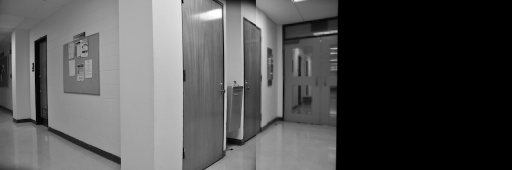

In [10]:
# v. Warp one image onto the other one, blending overlapping pixels together to
# create a single image that shows the union of all pixels from both input 
# images. You can choose which of the images to warp. The steps are as follows:

# A. Determine how big to make the final output image so that it contains the
# union of all pixels in the two images.

# B. Copy the image that does not have to be warped into the appropriate 
# location in the output.

# C. Warp the other image into the output image based on the estimated
# homography (or its inverse). You can use matlab functions if you want or 
# write your own warping function.

# D. Use any of the blending schemes we will discuss in class to blend pixels
# in the area of overlap between both images.

# https://stackoverflow.com/questions/38491959/how-to-apply-ransac-in-python-opencv
# https://medium.com/analytics-vidhya/panorama-formation-using-image-stitching-using-opencv-1068a0e8e47b

def warp(img1, img2, H):
    final_h = img1.shape[0]
    final_w = img1.shape[1] + img2.shape[1]

    warped_img = cv2.warpPerspective(img1, H, (final_w, final_h))
    warped_img[0:img2.shape[0], 0:img2.shape[1]] = img2

    return (final_w, final_h), warped_img


(final_x, final_y), warped_img = warp(r_img1, r_img2, M)
print('Final output image size: (width, height)')
print((final_x, final_y))
print('----------------------------------')

print('Stitched Image:')
cv2_imshow(warped_img)

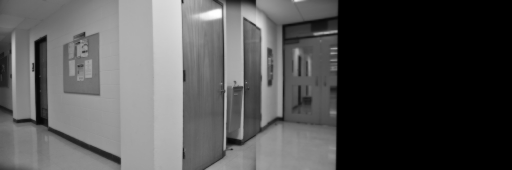

In [22]:
# apply blending

gauss_img = cv2.GaussianBlur(warped_img, (3,3), 0)
alpha = 0.5
beta = 1-alpha
blended_img = cv2.addWeighted(warped_img, alpha, gauss_img, beta, 0)

cv2_imshow(blended_img)